# First data explorations 

## This is also necessary for ascertaining some model assumptions

In this notebook we analyse the consumption and other country data a bit more in detail to see what are its systematics
We answer questions like 

1. What is the ratio between GDP per capita and consumption exp. per capita?  
2. How does this ratio change with cons. exp pc?
3. Is there a relationship between GDP per capita and carbon intensity? 

and more..

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.cm as cm
import warnings
import seaborn as sns
from math import ceil, sqrt
import os

# read the csv file data_nowcasted.extended.csv into a pandas dataframe from the data folder
data = pd.read_csv('./data/pip_all_data/data_nowcasted_extended.csv')


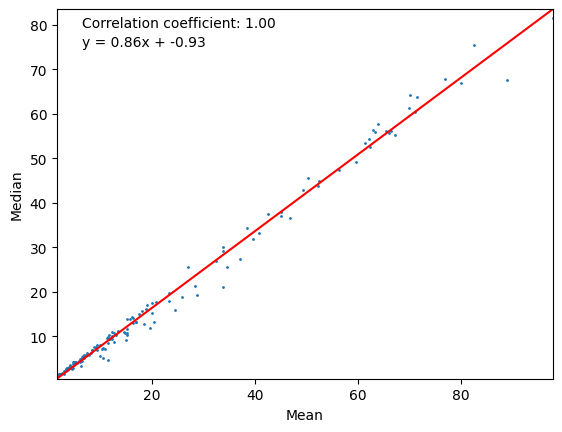

In [3]:
# Your existing code for scatterplot and linear fit line
plt.scatter(data['mean'], data['median'], s=1)
plt.plot(np.unique(data['mean']), np.poly1d(np.polyfit(data['mean'], data['median'], 1))(np.unique(data['mean'])), color='red')
plt.xlabel('Mean')
plt.ylabel('Median')
plt.margins(0)

# Calculating correlation coefficient and linear fit equation
correlation_coef = np.corrcoef(data['mean'], data['median'])[0][1]
linear_fit_eq = np.poly1d(np.polyfit(data['mean'], data['median'], 1))

# Formatting annotations with two significant digits
formatted_correlation = f"{correlation_coef:.2f}"
formatted_linear_fit_eq = f"y = {linear_fit_eq.coefficients[0]:.2f}x + {linear_fit_eq.coefficients[1]:.2f}"

# Annotating the plot
plt.annotate(f'Correlation coefficient: {formatted_correlation}', xy=(0.05, 0.95), xycoords='axes fraction')
plt.annotate(formatted_linear_fit_eq, xy=(0.05, 0.9), xycoords='axes fraction')

plt.show()


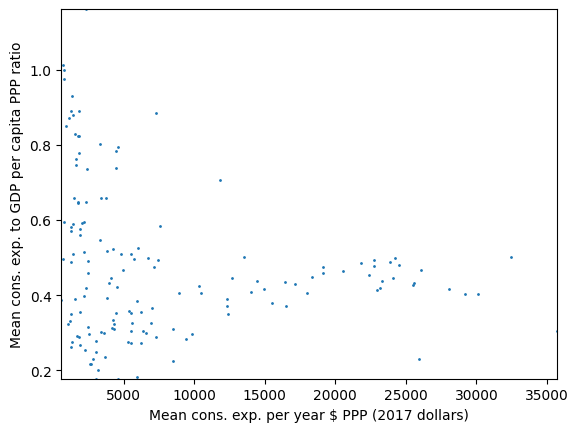

In [4]:
# calculate mean to gdp_pc_ppp ratio and plot as a scatter plot agasint the mean of the data dataframe
# calculate the mean to gdp_pc_ppp ratio
data['mean_to_gdp_pc_ppp_ratio'] = data['mean']*365/data['gdp_pc_ppp_2017']
# plot the mean_to_gdp_pc_ppp_ratio against the mean
plt.scatter(data['mean']*365, data['mean_to_gdp_pc_ppp_ratio'], s=1) # mean is multiplied by 365 to convert from mean per day to mean per year
plt.xlabel('Mean cons. exp. per year $ PPP (2017 dollars)')
plt.ylabel('Mean cons. exp. to GDP per capita PPP ratio')
plt.margins(0)
plt.show()

## Fit a model to this data which looks a potential energy function from physics e.g. Morse or lennard-jones potential
## But this is diffcult so we just fit a linear trend from 0 to 6000 and from 6000 to 3500

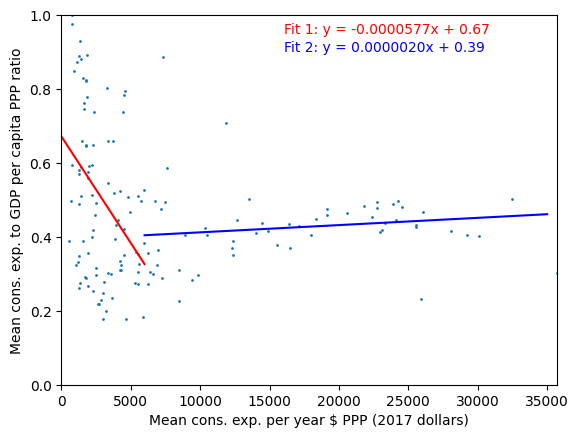

In [5]:
def linear_fit(data, x_col, y_col):
    return np.poly1d(np.polyfit(data[x_col], data[y_col], 1))

def quadratic_fit(data, x_col, y_col):
    return np.poly1d(np.polyfit(data[x_col], data[y_col], 2))

def power_law(x, a, b):
    return a * np.power(x, b)

def fit_and_plot(data, x_col, y_col):
    # Linear fits in specified ranges
    ranges = [(0, 6000), (6000, 35000)]
    linear_fits = []
    plot_colors = ['red', 'blue']  # Different color for each fit for clarity
    annotations = []

    for i, (start, end) in enumerate(ranges):
        mask = (data[x_col] >= start) & (data[x_col] <= end)
        fit = linear_fit(data[mask], x_col, y_col)
        linear_fits.append(fit)
        x_vals = np.linspace(start, end, 100)  # Use linspace for smooth line plotting
        plt.plot(x_vals, fit(x_vals), color=plot_colors[i])
        
        # Prepare annotation text for linear fit equations
        equation_text = f'Fit {i+1}: y = {fit[1]:.7f}x + {fit[0]:.2f}'
        annotations.append(equation_text)

    # Plotting annotations in the upper right corner, one above each other
    for i, text in enumerate(annotations):
        plt.annotate(text, xy=(0.45, 0.95 - i*0.05), xycoords='axes fraction', color=plot_colors[i])

    plt.scatter(data[x_col], data[y_col], s=1)
    plt.xlabel('Mean cons. exp. per year $ PPP (2017 dollars)')
    plt.ylabel('Mean cons. exp. to GDP per capita PPP ratio')
    plt.margins(0)
    plt.ylim(0, 1)
    plt.show()

# Note: Before using 'fit_and_plot', ensure 'data' DataFrame is defined and contains
# the necessary columns ('mean', 'gdp_pc_ppp_2017', etc.) as per your data structure.

# Adding a temporary column
data['temp_mean_yearly'] = data['mean']*365

# Updated example usage
data['mean_to_gdp_pc_ppp_ratio'] = data['mean']*365/data['gdp_pc_ppp_2017']
fit_and_plot(data, 'temp_mean_yearly', 'mean_to_gdp_pc_ppp_ratio')

##### the outcome of the above plotting exercise is basically that it makes, when keeping things super simple, sense to let countries have their current ratios up to mean cons.exp per year of 10000 and then fix the ratio at 0.4 or slightly above (although this is a cross country analysis and it does not necessarily tell us anything about individual country trajectories)

# Now check whether there is a relationship between GDP and carbon intensity

There is likely no cross-country relationship but that does not mean there is no relationship for each country individually over time.
Does faster economic growth lead to faster or slower or unchanged carbon intensity reduction?

Text(0, 0.5, 'Carbon intensity (kg CO2 per 2017 dollars)')

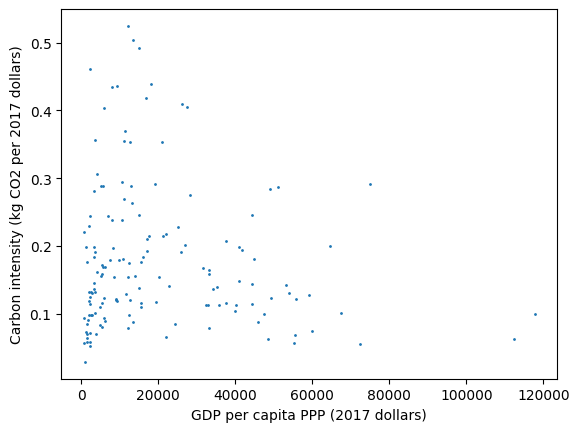

In [6]:
# plot on a scatterplot gdp_ppp_pc_2017 against carbon_intensity
plt.scatter(data['gdp_pc_ppp_2017'], data['carbon_intensity'], s=1)
plt.xlabel('GDP per capita PPP (2017 dollars)')
plt.ylabel('Carbon intensity (kg CO2 per 2017 dollars)')

## Check whether there is a relationship between economic growth and technology evolution i.e. carbon intensity reduction

     country_code  gdp_pc_ppp_change_rate  carbon_intensity_change_rate
0             ABW                0.024028                           NaN
1             ABW               -0.018394                           NaN
2             ABW                0.056370                           NaN
3             ABW               -0.022649                           NaN
4             ABW               -0.012556                           NaN
...           ...                     ...                           ...
2655          ZWE               -0.011779                     -0.136112
2656          ZWE                0.019748                     -0.100730
2657          ZWE                0.029094                      0.077781
2658          ZWE               -0.081773                     -0.017707
2659          ZWE               -0.096704                     -0.114667

[2660 rows x 3 columns]


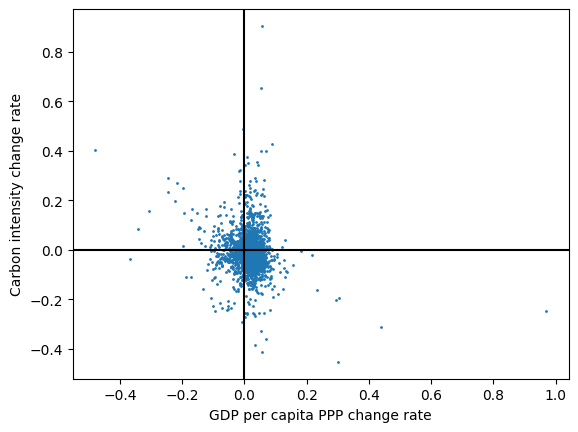

In [7]:
# import gdp_pc_ppp and carbon_intensity into numpy arrays then loop over all countries and compute for gdp per capita and carbon intensity the change rate from year to year from 2010 to 2020
# import gdp_pc_ppp and carbon_intensity from the csv data file which is not loaded yet into dataframes
# Importing the data
gdp_pc_ppp = pd.read_csv('./data/pip_all_data/gdp_pc_ppp.csv', sep=';')
carbon_intensity = pd.read_csv('./data/pip_all_data/carbon_intensity.csv')

# Assuming 'data' is another DataFrame that contains 'country_code'
# countries = data['country_code'].unique()
countries = gdp_pc_ppp['Country Code'].unique()  # Modify as per your actual DataFrame
years = list(np.arange(2010, 2021))

# Initialize an empty DataFrame for storing all change rates
all_change_rates_df = pd.DataFrame()

for country in countries:
    #print(country)
    # Get the index for the current country in each DataFrame
    country_row_gdp = gdp_pc_ppp[gdp_pc_ppp['Country Code'] == country].index[0]
    country_row_ci = carbon_intensity[carbon_intensity['Country Code'] == country].index[0]

    # Extracting the values for each year
    gdp_pc_ppp_values = [gdp_pc_ppp.at[country_row_gdp, str(year)] for year in years]
    carbon_intensity_values = [carbon_intensity.at[country_row_ci, str(year)] for year in years]

    # Computing the change rate
    gdp_pc_ppp_change_rate = [(gdp_pc_ppp_values[i+1] - gdp_pc_ppp_values[i]) / gdp_pc_ppp_values[i] for i in range(len(years) - 1)]
    carbon_intensity_change_rate = [(carbon_intensity_values[i+1] - carbon_intensity_values[i]) / carbon_intensity_values[i] for i in range(len(years) - 1)]

    # Creating a dictionary for the change rates
    change_rate_dict = {
        'country_code': country,
        'gdp_pc_ppp_change_rate': gdp_pc_ppp_change_rate,
        'carbon_intensity_change_rate': carbon_intensity_change_rate
    }

    # Convert the dictionary to a DataFrame
    change_rate_df = pd.DataFrame(change_rate_dict)

    # Append this DataFrame to the cumulative DataFrame
    all_change_rates_df = pd.concat([all_change_rates_df, change_rate_df], ignore_index=True)

# The final DataFrame contains all the change rates for each country
print(all_change_rates_df)


# save this dataframe as a csv file
all_change_rates_df.to_csv('./data/pip_all_data/all_change_rates.csv', index=False)

# plot on a scatterplot gdp change rate against carbon intensity change rate
plt.scatter(all_change_rates_df['gdp_pc_ppp_change_rate'], all_change_rates_df['carbon_intensity_change_rate'], s=1)
plt.xlabel('GDP per capita PPP change rate')
plt.ylabel('Carbon intensity change rate')
# add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-')
# add a vertical line at x=0
plt.axvline(x=0, color='black', linestyle='-')

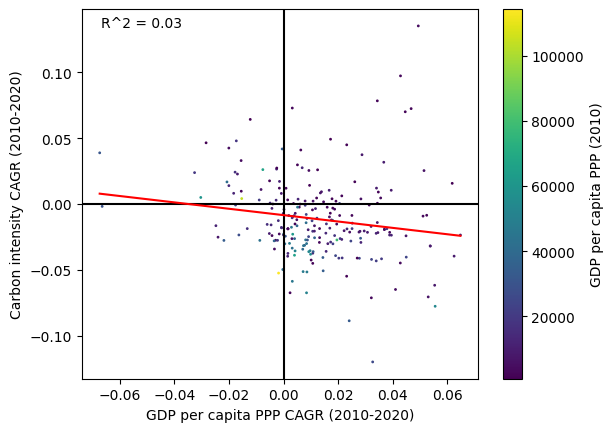

In [8]:
# Assuming 'data' is another DataFrame that contains 'country_code'
countries = gdp_pc_ppp['Country Code'].unique()  # Modify as per your actual DataFrame
years = list(np.arange(2010, 2021))

# Initialize an empty list for storing CAGR data
cagr_data = []

for country in countries:
    #print(country)
    # Get the index for the current country in each DataFrame
    country_row_gdp = gdp_pc_ppp[gdp_pc_ppp['Country Code'] == country].index[0]
    country_row_ci = carbon_intensity[carbon_intensity['Country Code'] == country].index[0]

    # Extracting the values for the first and last year
    gdp_start = gdp_pc_ppp.at[country_row_gdp, str(years[0])]
    gdp_end = gdp_pc_ppp.at[country_row_gdp, str(years[-1])]
    ci_start = carbon_intensity.at[country_row_ci, str(years[0])]
    ci_end = carbon_intensity.at[country_row_ci, str(years[-1])]

    # Computing CAGR
    n_years = years[-1] - years[0]
    gdp_cagr = (gdp_end / gdp_start) ** (1/n_years) - 1
    ci_cagr = (ci_end / ci_start) ** (1/n_years) - 1

    # Appending the result to the list
    cagr_data.append({
        'country_code': country, 
        'gdp_pc_ppp_cagr': gdp_cagr, 
        'carbon_intensity_cagr': ci_cagr
    })

# Convert the list of dictionaries to a DataFrame
cagr_df = pd.DataFrame(cagr_data)

# Add GDP per capita PPP for 2010 to cagr_data
for item in cagr_data:
    country_code = item['country_code']
    country_row = gdp_pc_ppp[gdp_pc_ppp['Country Code'] == country_code].index[0]
    item['gdp_pc_ppp_2010'] = gdp_pc_ppp.at[country_row, '2010']  # Assuming '2010' is the column name

# Update cagr_df with the new data
cagr_df = pd.DataFrame(cagr_data)


# Save the CAGR DataFrame as a CSV file
cagr_df.to_csv('./data/pip_all_data/cagr.csv', index=False)

# Remove any rows with NaN or infinite values
cleaned_cagr_df = cagr_df.dropna().replace([np.inf, -np.inf], np.nan).dropna()

## Create a colormap for the scatter plot
norm = plt.Normalize(cleaned_cagr_df['gdp_pc_ppp_2010'].min(), cleaned_cagr_df['gdp_pc_ppp_2010'].max())
colors = cm.viridis(norm(cleaned_cagr_df['gdp_pc_ppp_2010']))

# Check if there are enough unique values to perform linear regression
if len(np.unique(cleaned_cagr_df['gdp_pc_ppp_cagr'])) > 1 and len(np.unique(cleaned_cagr_df['carbon_intensity_cagr'])) > 1:
    # Fit the linear model
    coefficients = np.polyfit(cleaned_cagr_df['gdp_pc_ppp_cagr'], cleaned_cagr_df['carbon_intensity_cagr'], 1)
    polynomial = np.poly1d(coefficients)
    x_axis = np.linspace(cleaned_cagr_df['gdp_pc_ppp_cagr'].min(), cleaned_cagr_df['gdp_pc_ppp_cagr'].max(), 100)
    y_axis = polynomial(x_axis)

    # Plotting the CAGR values
    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.scatter(cleaned_cagr_df['gdp_pc_ppp_cagr'], cleaned_cagr_df['carbon_intensity_cagr'], color=colors, s=1)
    ax.set_xlabel('GDP per capita PPP CAGR (2010-2020)')
    ax.set_ylabel('Carbon intensity CAGR (2010-2020)')
    ax.axhline(y=0, color='black', linestyle='-')
    ax.axvline(x=0, color='black', linestyle='-')
    # Add a linear fit line
    ax.plot(x_axis, y_axis, color='red')
    # Color countries based on their absolute GDP per capita PPP in 2010
    # Adding a colorbar for reference
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, label='GDP per capita PPP (2010)')
    # plot the R^2 value
    r_squared = np.corrcoef(cleaned_cagr_df['gdp_pc_ppp_cagr'], cleaned_cagr_df['carbon_intensity_cagr'])[0][1] ** 2
    ax.annotate(f'R^2 = {r_squared:.2f}', xy=(0.05, 0.95), xycoords='axes fraction')

    plt.show()
else:
    print("Insufficient variability in data for linear regression.")

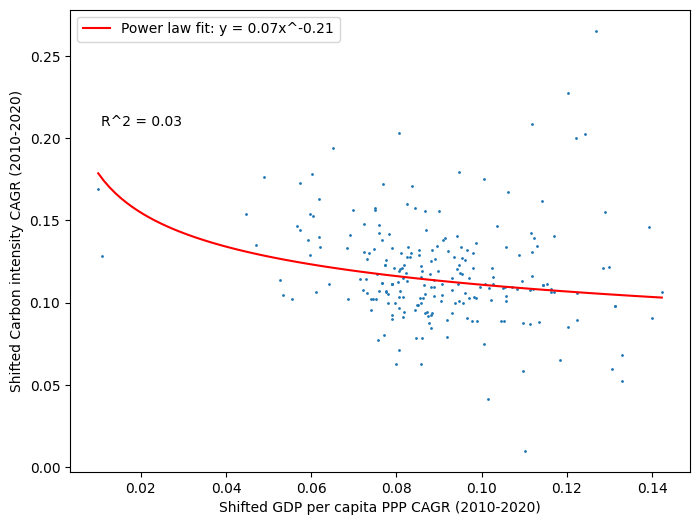

Elasticity of carbon intensity reduction with respect to GDP CAGR: -0.21


In [9]:
# Now fit a power law also

# ... [Your existing code ends here] ...

# Shift the data to make all values positive
min_gdp_cagr = np.abs(cleaned_cagr_df['gdp_pc_ppp_cagr'].min())
min_ci_cagr = np.abs(cleaned_cagr_df['carbon_intensity_cagr'].min())
cleaned_cagr_df['shifted_gdp_cagr'] = cleaned_cagr_df['gdp_pc_ppp_cagr'] + min_gdp_cagr + 0.01  # Avoid zero values
cleaned_cagr_df['shifted_ci_cagr'] = cleaned_cagr_df['carbon_intensity_cagr'] + min_ci_cagr + 0.01

# Log-transform the data
cleaned_cagr_df['log_gdp_cagr'] = np.log(cleaned_cagr_df['shifted_gdp_cagr'])
cleaned_cagr_df['log_ci_cagr'] = np.log(cleaned_cagr_df['shifted_ci_cagr'])

# Fit a linear model to the log-transformed data
coefficients, _ = np.polyfit(cleaned_cagr_df['log_gdp_cagr'], cleaned_cagr_df['log_ci_cagr'], 1, cov=True)

# The power law relationship: y = ax^b becomes linear when log-transformed: log(y) = log(a) + b*log(x)
a = np.exp(coefficients[1])  # Intercept is log(a), so a = exp(intercept)
b = coefficients[0]  # Slope is the exponent in the power law

# Create the power law function for plotting
def power_law(x, a, b):
    return a * np.power(x, b)

# Generate x values for plotting the power law
x_values = np.linspace(cleaned_cagr_df['shifted_gdp_cagr'].min(), cleaned_cagr_df['shifted_gdp_cagr'].max(), 100)

# Plotting the power law model
plt.figure(figsize=(8, 6))
plt.scatter(cleaned_cagr_df['shifted_gdp_cagr'], cleaned_cagr_df['shifted_ci_cagr'], s=1)
plt.plot(x_values, power_law(x_values, a, b), color='red', label=f'Power law fit: y = {a:.2f}x^{b:.2f}')
plt.xlabel('Shifted GDP per capita PPP CAGR (2010-2020)')
plt.ylabel('Shifted Carbon intensity CAGR (2010-2020)')
plt.legend()
#plt.xscale('log')
#plt.yscale('log')
# plot the R^2 value
plt.annotate(f'R^2 = {np.corrcoef(cleaned_cagr_df["shifted_gdp_cagr"], cleaned_cagr_df["shifted_ci_cagr"])[0][1]**2:.2f}', xy=(0.05, 0.75), xycoords='axes fraction')
plt.show()

# Print the elasticity (exponent b in the power law)
print(f"Elasticity of carbon intensity reduction with respect to GDP CAGR: {b:.2f}")

### Replicate logarithmic model of gdp pc determining carbon intensity trend 2010 to 2020 from graph made

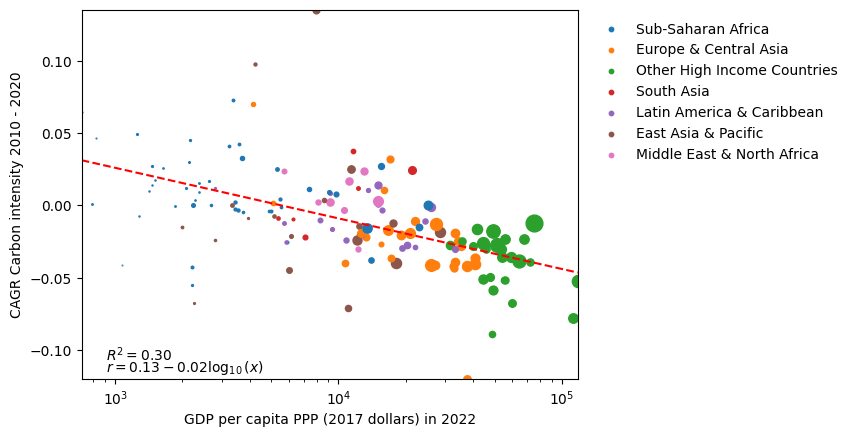

In [10]:
# plot from the dataframe data_nowcasted.extended.csv the column gdp_pc_ppp_2017 against the column carbon_intensity_trend but by looping over all countries
# Assuming 'data' is another DataFrame that contains 'country_code'
countries = data['country_code'].unique()  # Modify as per your actual DataFrame
# set up figure and ax for the plot
fig, ax = plt.subplots()
# make a list for the x and y values so we can fit a line later on
list_values_gdp = []
list_values_carbon_intensity = []
# create mapping between region and color based on regions in data dataframe so in the column region_name
region_color_mapping = {region: color for region, color in zip(data['region_name'].unique(), cm.tab10.colors)}
# make a set to keep track of which regions have appeared already in an earlier loop iteration
regions_appeared = set()
# loop over all countries and plot the gdp_pc_ppp_2017 against the carbon_intensity_trend
for country in countries:
    
    country_data = data[data['country_code'] == country]
    # make size of marker dependent on the carbon emissions per capita in 2022 from the columns gdp_pc_ppp_2017 and carbon_intensity which need to multiplied together
    size = country_data['gdp_pc_ppp_2017'] * country_data['carbon_intensity'] / (1e2*1.5)
    region = country_data['region_name'].values[0]
    color = region_color_mapping[country_data['region_name'].values[0]]
   
    # keep track of which region has appeared already in an earlier loop iteration with a set
    if region in regions_appeared:
        label = None
    else:
        label = region
        regions_appeared.add(region)
    
    # plot the scatter plot
    ax.scatter(country_data['gdp_pc_ppp_2017'], 
               country_data['carbon_intensity_trend'],
               s=size,
               color = color,
               label=label)

# label the axes
ax.set_xlabel('GDP per capita PPP (2017 dollars) in 2022')
ax.set_ylabel('CAGR Carbon intensity 2010 - 2020')
# plot a logarithmic fit line
coefficients = np.polyfit(np.log(data['gdp_pc_ppp_2017']), data['carbon_intensity_trend'], 1)
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(np.log(data['gdp_pc_ppp_2017']).min(), np.log(data['gdp_pc_ppp_2017']).max(), 100)


# Introducing an offset to the logarithmic fit line
offset_c = 0  # Define your offset here

y_axis = polynomial(x_axis) + offset_c
ax.plot(np.exp(x_axis), y_axis, color='red', linestyle='--')
# Calculate and annotate the R^2 value
r_squared = np.corrcoef(np.log(data['gdp_pc_ppp_2017']), data['carbon_intensity_trend'])[0][1] ** 2
ax.annotate(r'$R^2 = {:.2f}$'.format(r_squared), xy=(0.05, 0.05), xycoords='axes fraction')
# Annotate the equation of the logarithmic fit line call the y axis small r for rate of change here and throughout the code and paper
ax.annotate(r'$r = {:.2f} - {:.2f}\log_{{10}}(x)$'.format(polynomial[0], abs(polynomial[1])), xy=(0.05, 0.02), xycoords='axes fraction')
lgnd = ax.legend(loc='upper right', bbox_to_anchor=(1.55, 1), frameon=False)
# Set a fixed marker size for all legend markers
for handle in lgnd.legend_handles:
    handle.set_sizes([10])  # Adjust the number inside the list to change the size
# log scale the x axis
ax.set_xscale('log')
ax.margins(0)
# save plot as high resolution png file
plt.savefig('./gdp_pc_vs_carbon_intensity_trend.png', dpi=300, bbox_inches='tight')

plt.show()

### another pattern we have to investigate is population growth as a function of gdp per capita
##### Murphy, Thomas W, Jr shows in https://escholarship.org/uc/item/9js5291m that net pop growth rate, without migration, negatively correlates with gdp per capita. replicate this and ascertain an elasticity

Country SSD has NaN values for one or both variables.
Fit line: y = -0.0190 * log10(x) + 0.0874
Elasticity of birth rate with respect to GDP per capita PPP: -0.25


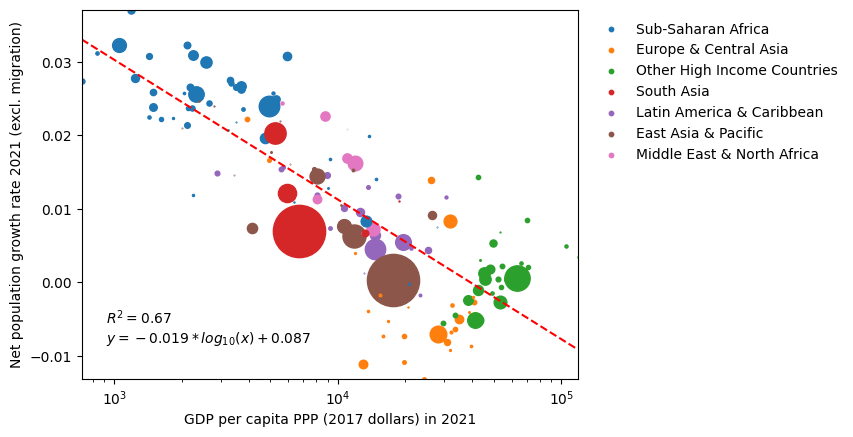

In [11]:
# import the csv file birth_and_death_rate.csv into a pandas dataframe
birth_and_death_rate = pd.read_csv('./data/pip_all_data/birth_and_death_rate.csv', sep=';')
# only use the country codes that are in the dataframe data_nowcasted_extended in the column country_code by make a list of the unique values in the column country_code
countries = data['country_code'].unique()
# make a list for the x and y values so we can fit a line later on
list_values_gdp = []
list_values_net = []
# create mapping between region and color based on regions in data dataframe so in the column region_name
region_color_mapping = {region: color for region, color in zip(data['region_name'].unique(), cm.tab10.colors)}
# make a set to keep track of which regions have appeared already in an earlier loop iteration
regions_appeared = set()
# define plot and axis on which all the scatter plots will be plotted
fig, ax = plt.subplots()
# loop over all countries
for country in countries:
    # Get the index for the current country in each DataFrame
    country_row_gdp = gdp_pc_ppp[gdp_pc_ppp['Country Code'] == country].index[0]
    country_row_bd = birth_and_death_rate[birth_and_death_rate['Country Code'] == country].index[0]
    #print(country_row_gdp, country_row_bd)

    # only plot for 2021
    gdp_pc_ppp_values = gdp_pc_ppp.at[country_row_gdp, '2021']
    net_values = birth_and_death_rate.at[country_row_bd, 'net']
    # check whether the values are not NaN
    if np.isnan(gdp_pc_ppp_values) or np.isnan(net_values):
        print(f"Country {country} has NaN values for one or both variables.")
        continue # The continue statement skips the current iteration of the loop and the control flow of the program goes to the next iteration.

    # find region of the country in the data dataframe
    region = data[data['country_code'] == country]['region_name'].values[0]
    
    # keep track of which region has appeared already in an earlier loop iteration with a set
    if region in regions_appeared:
        label = None
    else:
        label = region
        regions_appeared.add(region)

    size = data[data['country_code'] == country]['population'].values[0] / 1e6  # Population size in millions
    # Plot the data and set color according to region in data dataframe and determine size of the points according to population size in the dataframe data column population
    ax.scatter(gdp_pc_ppp_values, net_values, s=size, color=region_color_mapping[region], label=label)

    # label the axes
    ax.set_xlabel('GDP per capita PPP (2017 dollars) in 2021')
    ax.set_ylabel('Net population growth rate 2021 (excl. migration)')
    # log the x axis
    ax.set_xscale('log')
    # no margins
    ax.margins(0)

    # save all the countries in a list for x and y values so we can plot a fit line later on outside the loop together with the country code as a tuple
    list_values_gdp.append(gdp_pc_ppp_values)
    list_values_net.append(net_values)


if len(list_values_gdp) > 1:  # Ensure there's more than one data point
    try:
       # Fit a simple linear fit line to the log10 of the data
        coefficients = np.polyfit(np.log10(list_values_gdp), list_values_net, 1)
        # Create a polynomial object with the coefficients
        linear_fit_function = np.poly1d(coefficients)
        
        # Print the coefficients of the fit line with 4 decimal places
        print(f"Fit line: y = {coefficients[0]:.4f} * log10(x) + {coefficients[1]:.4f}")
        
        # Generate x values for plotting the fit line
        log_x_values = np.linspace(np.log10(min(list_values_gdp)), np.log10(max(list_values_gdp)), 100)
        y_values_fit = linear_fit_function(log_x_values)
        
        # Plot the fit line
        ax.plot(10**log_x_values, y_values_fit, color='red', linestyle='--')  # Convert log_x_values back to original scale
        
        # Calculate and plot the R^2 value
        correlation_matrix = np.corrcoef(np.log10(list_values_gdp), list_values_net)
        r_squared = correlation_matrix[0, 1] ** 2
        ax.annotate(r'$R^2 = {:.2f}$'.format(r_squared), xy=(0.05, 0.15), xycoords='axes fraction')
        
        # Annotate the equation of the linear fit line
        ax.annotate(r'$y = {0:.3f} * log_{{10}}(x) + {1:.3f}$'.format(coefficients[0], coefficients[1]), xy=(0.05, 0.1), xycoords='axes fraction')
        
        # Modify legend handling as required (no changes needed here from your original code)
        lgnd = ax.legend(loc='upper right', bbox_to_anchor=(1.55, 1), frameon=False)
        for handle in lgnd.legend_handles:
            handle.set_sizes([10])

    except np.linalg.LinAlgError:
        print("Error: SVD did not converge. Check your data for issues.")
else:
    print("Insufficient valid data points for fitting.")
    

# compute an elasticity of birth rate with respect to GDP per capita PPP
# Shift the data to make all values positive
min_net = np.abs(min(list_values_net))
# Avoid zero values
shifted_net = np.array(list_values_net) + min_net + 0.01
# now compute the elasticity via log log regression, the coefficient is the elasticity
coefficients = np.polyfit(np.log(list_values_gdp), np.log(shifted_net), 1)

# Print the elasticity which is the coefficient multiplication factor of the log log regression
print(f"Elasticity of birth rate with respect to GDP per capita PPP: {coefficients[0]:.2f}")

# save plot as high resolution png file
plt.savefig('./data/pip_all_data/gdp_per_capita_ppp_vs_net_population_growth_rate.png', dpi=300, bbox_inches='tight')


### Plot both the graphs together above as panels A and B of the same plot

Country SSD has NaN values for one or both variables.


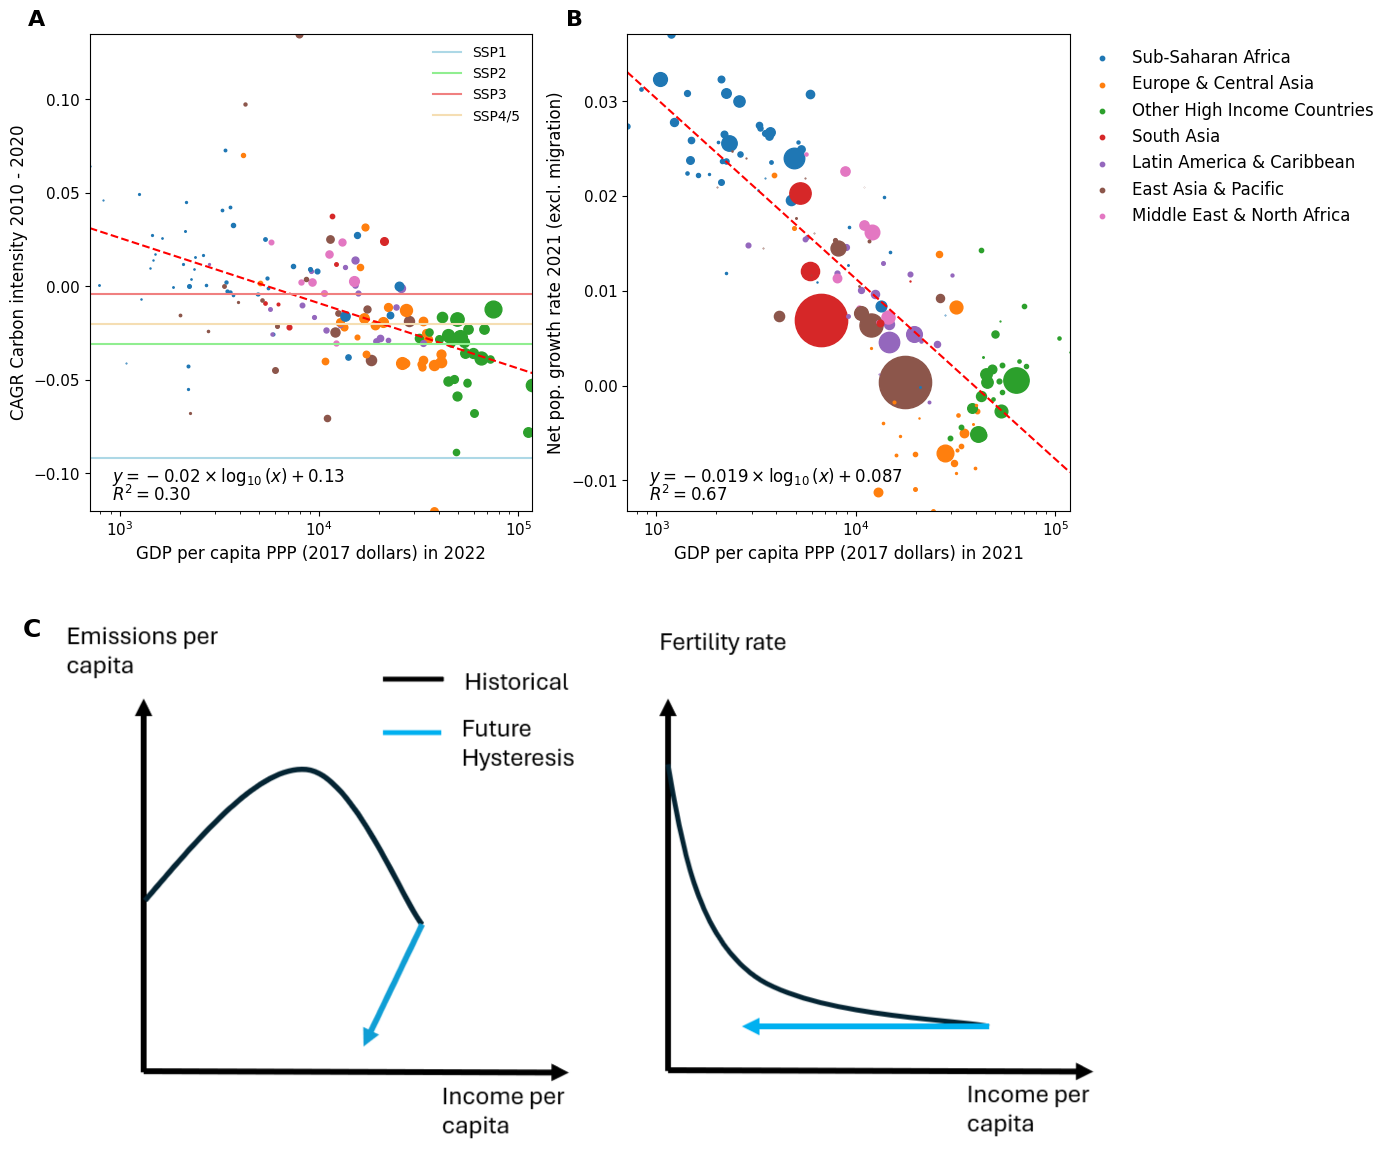

In [12]:
### Plot both the graphs together above as panels A and B of the same plot

# Assuming necessary imports, data preparation, and variables like `countries`, `data`, `gdp_pc_ppp`, `birth_and_death_rate`, `region_color_mapping`, etc., are defined above.
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.gridspec as gridspec


# Set up figure and GridSpec layout
fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], figure=fig)  # Adjust height ratios if needed

# Define subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])  # Ensuring ax3 spans the entire second row

regions_appeared = set()

# Plot 1: Scatter plot of GDP per capita PPP against carbon intensity trend
for country in countries:
    country_data = data[data['country_code'] == country]
    size = country_data['gdp_pc_ppp_2017'] * country_data['carbon_intensity'] / (1e2*1.5)
    region = country_data['region_name'].values[0]
    color = region_color_mapping[region]
    if region in regions_appeared:
        label = None
    else:
        label = region
        regions_appeared.add(region)
    ax1.scatter(country_data['gdp_pc_ppp_2017'], 
                country_data['carbon_intensity_trend'],
                s=size,
                color=color,
                label=label)

# Configurations for Plot 1
ax1.set_xlabel('GDP per capita PPP (2017 dollars) in 2022', fontsize = 12)
ax1.set_ylabel('CAGR Carbon intensity 2010 - 2020', fontsize = 12)
ax1.set_xscale('log')
ax1.margins(0)
ax1.tick_params(axis='both', which='major', labelsize=11)  # Change '11' to your desired size

# Plot a logarithmic fit line for the first plot
coefficients = np.polyfit(np.log(data['gdp_pc_ppp_2017']), data['carbon_intensity_trend'], 1)
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(np.log(data['gdp_pc_ppp_2017']).min(), np.log(data['gdp_pc_ppp_2017']).max(), 100)
y_axis = polynomial(x_axis)
ax1.plot(np.exp(x_axis), y_axis, color='red', linestyle='--')

# Calculate and annotate the R^2 value for the first plot
r_squared = np.corrcoef(np.log(data['gdp_pc_ppp_2017']), data['carbon_intensity_trend'])[0][1] ** 2
ax1.annotate(r'$R^2 = {:.2f}$'.format(r_squared), xy=(0.05, 0.02), xycoords='axes fraction', fontsize = 12)

# Annotate the equation of the logarithmic fit line for the first plot
ax1.annotate(r'$y = {:.2f} \times \log_{{10}}(x) + {:.2f}$'.format(coefficients[0], coefficients[1]), xy=(0.05, 0.06), xycoords='axes fraction', fontsize = 12)



# Labeling Panel A
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# in axis1 draw horizontal line at -0.092, -0.031, -0.004 and -0.02. call it ssp1, ssp2, ssp3 and ssp4/5 respectively use these colors colors = ['lightblue', 'lightgreen', 'lightcoral', 'wheat']
# Draw horizontal lines at specified y-values
colors = ['lightblue', 'lightgreen', 'lightcoral', 'wheat']
y_values = [-0.092, -0.031, -0.004, -0.02]
ssp_labels = ['SSP1', 'SSP2', 'SSP3', 'SSP4/5']
for y, color, label in zip(y_values, colors, ssp_labels):
    ax1.axhline(y=y, color=color, linestyle='-', label=label)

#plot corresponding legend only for the ssp lines and the linear fit line, not any other data points
handles, labels = ax1.get_legend_handles_labels()
handles = [h for h in handles if 'SSP' in h.get_label() or 'Fit' in h.get_label()]
labels = [l for l in labels if 'SSP' in l or 'Fit' in l]
# legend location inside the plot upper right
ax1.legend(handles, labels, loc='upper right', frameon=False)

regions_appeared.clear()  # Reset for the second plot
list_values_gdp = []
list_values_net = []

# Plot 2: Scatter plot of GDP per capita PPP against net population growth rate
for country in countries:
    country_row_gdp = gdp_pc_ppp[gdp_pc_ppp['Country Code'] == country].index[0]
    country_row_bd = birth_and_death_rate[birth_and_death_rate['Country Code'] == country].index[0]
    gdp_pc_ppp_values = gdp_pc_ppp.at[country_row_gdp, '2021']
    net_values = birth_and_death_rate.at[country_row_bd, 'net']
    if np.isnan(gdp_pc_ppp_values) or np.isnan(net_values):
        print(f"Country {country} has NaN values for one or both variables.")
        continue
    region = data[data['country_code'] == country]['region_name'].values[0]
    size = data[data['country_code'] == country]['population'].values[0] / 1e6  # Population size in millions
    color = region_color_mapping[region]
    label = region if region not in regions_appeared else None
    regions_appeared.add(region)  # Ensure each region is added once
    ax2.scatter(gdp_pc_ppp_values, net_values, s=size, color=color, label=label)
    list_values_gdp.append(gdp_pc_ppp_values)
    list_values_net.append(net_values)

# Configurations for Plot 2
ax2.set_xlabel('GDP per capita PPP (2017 dollars) in 2021', fontsize = 12)
ax2.set_ylabel('Net pop. growth rate 2021 (excl. migration)', fontsize = 12)
ax2.set_xscale('log')
# Adjust tick label size
ax2.tick_params(axis='both', which='major', labelsize=11)  # Change '11' to your desired size

ax2.margins(0)

# Fit a simple linear fit line to the log10 of the data for the second plot
coefficients = np.polyfit(np.log10(list_values_gdp), list_values_net, 1)
linear_fit_function = np.poly1d(coefficients)
log_x_values = np.linspace(np.log10(min(list_values_gdp)), np.log10(max(list_values_gdp)), 100)
y_values_fit = linear_fit_function(log_x_values)
ax2.plot(10**log_x_values, y_values_fit, color='red', linestyle='--')

# Calculate and plot the R^2 value for the second plot, positioned in the left lower corner
correlation_matrix = np.corrcoef(np.log10(list_values_gdp), list_values_net)
r_squared = correlation_matrix[0, 1] ** 2
ax2.annotate(r'$R^2 = {:.2f}$'.format(r_squared), xy=(0.05, 0.02), xycoords='axes fraction', fontsize = 12)

# Annotate the equation of the linear fit line for the second plot, also in the left lower corner
ax2.annotate(r'$y = {:.3f} \times \log_{{10}}(x) + {:.3f}$'.format(coefficients[0], coefficients[1]), xy=(0.05, 0.06), xycoords='axes fraction', fontsize = 12)

# Labeling Panel B in the upper left corner
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')


# Modify legend handling for the second plot to place it outside
lgnd = ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize = 12)
for handle in lgnd.legend_handles:
    handle.set_sizes([10])

# Load and add image to ax3
img = plt.imread('.\\panel_c_figure_1.png')  # Ensure correct path and file extension
imagebox = OffsetImage(img, zoom=0.35)
ab = AnnotationBbox(imagebox, (0.5, 0.5), frameon=False, box_alignment=(0.5, 0.5), xycoords='axes fraction')
ax3.add_artist(ab)
ax3.axis('off')  # Ensure no axis is visible for clarity

# Annotate Panel C for clarity
ax3.text(-0.05, 1.05, 'C', transform=ax3.transAxes, fontsize=18, fontweight='bold', va='top', ha='right')

plt.tight_layout()
# Save plot as high-resolution PNG file
plt.savefig('fig1.png', dpi=300, bbox_inches='tight')
plt.show()


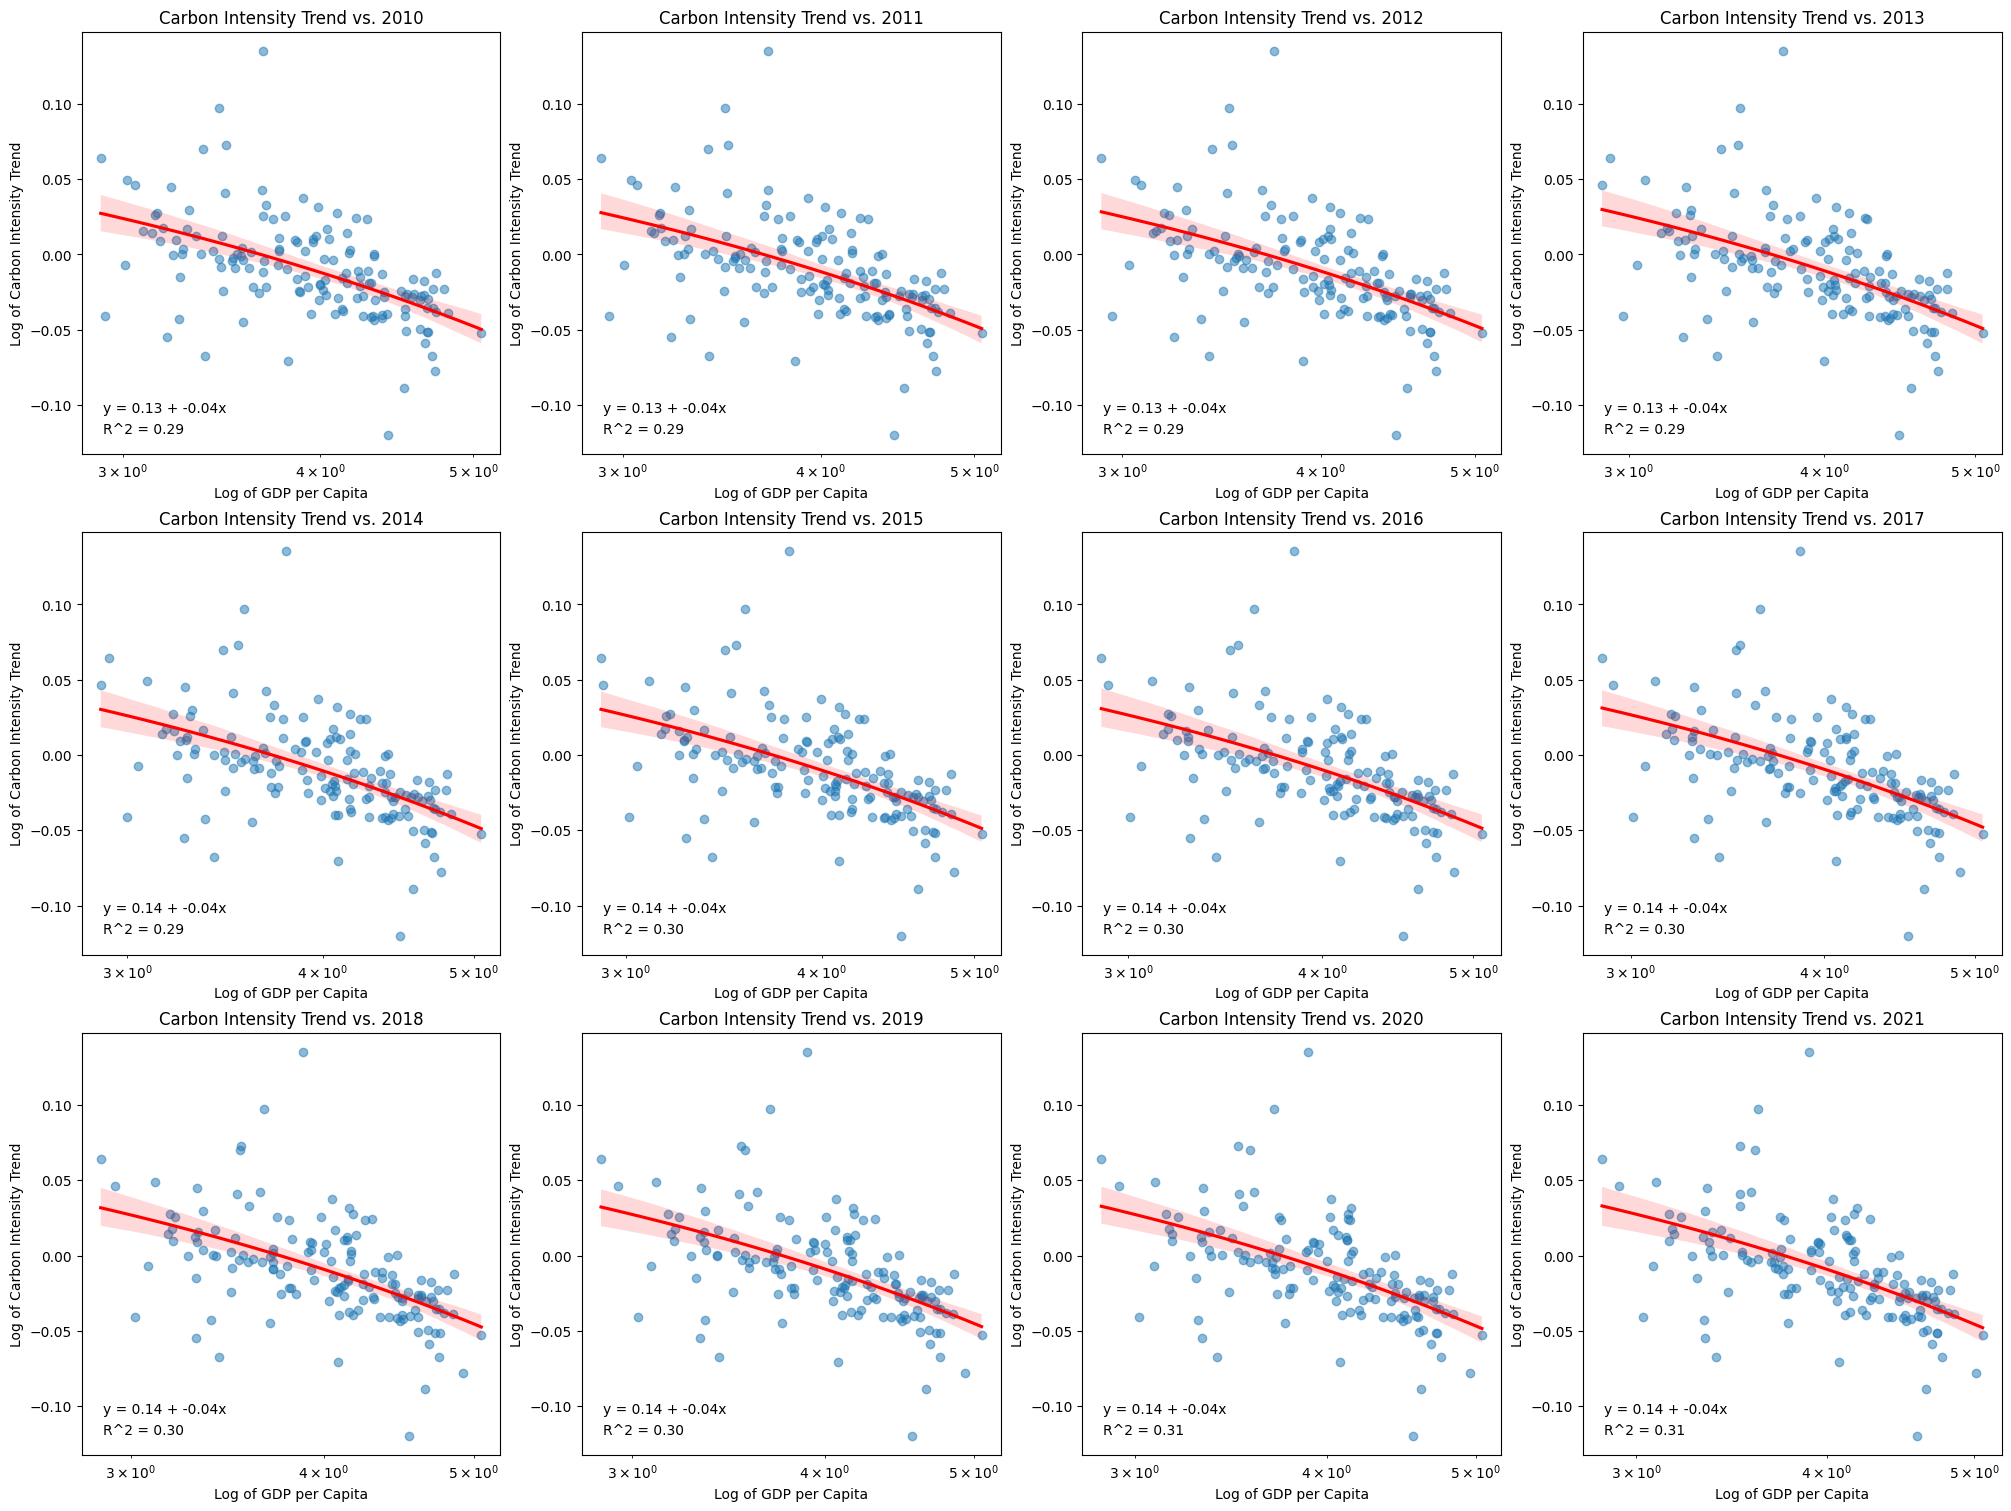

In [13]:
# import co2-emissions-and-gdp-per-capita.csv into a pandas dataframe already and check whether other gdp pc  on axis in panel A above the relationship still holds
# Importing the data
from scipy.stats import linregress
co2_emissions_gdp = pd.read_csv('./data/carbon_intensity_trend_vs_gdppc.csv', sep=';')

years = [str(year) for year in range(2010, 2022)]

# Prepare the grid
n_cols = 4
n_rows = len(years) // n_cols + (len(years) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5), constrained_layout=True)

for i, year in enumerate(years):
    ax = axes.flatten()[i]
    # Since there's no 'logy' in regplot, we set log scale on axes directly
    ax.set(xscale="log")
    
    # Plot with seaborn
    sns.regplot(x=np.log10(co2_emissions_gdp[year]), y=co2_emissions_gdp['carbon_intensity_trend'], ax=ax, 
                scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    
    # calculate the linear fit equation and the R squared and plot in lower left corner of panel
    slope, intercept, r_value, p_value, std_err = linregress(np.log10(co2_emissions_gdp[year]), co2_emissions_gdp['carbon_intensity_trend'])
    ax.annotate(f'R^2 = {r_value**2:.2f}', xy=(0.05, 0.05), xycoords='axes fraction')
    ax.annotate(f'y = {intercept:.2f} + {slope:.2f}x', xy=(0.05, 0.1), xycoords='axes fraction')
    
    
    ax.set_title(f'Carbon Intensity Trend vs. {year}')
    ax.set_xlabel('Log of GDP per Capita')
    ax.set_ylabel('Log of Carbon Intensity Trend')

# Hide unused subplots
for j in range(i + 1, n_rows * n_cols):
    axes.flatten()[j].set_visible(False)

plt.show()

## Plot radical convergence compared to SSPs

(0.05, 0.05)
60307.695700000004
0.22000000000000003
(0.05, 0.05)
47922.65862
0.25
(5000, -0.05)
29328.07825
0.29000000000000004
(5000, -0.05)
42497.85396
0.49000000000000005
(0.05, 0.05)
72881.90409
0.27
(10000, 0.07)
65000.0
0.07
(12000, 0.05)
39500.0
0.05
(15000, -0.05)
32500.0
0.47500000000000003


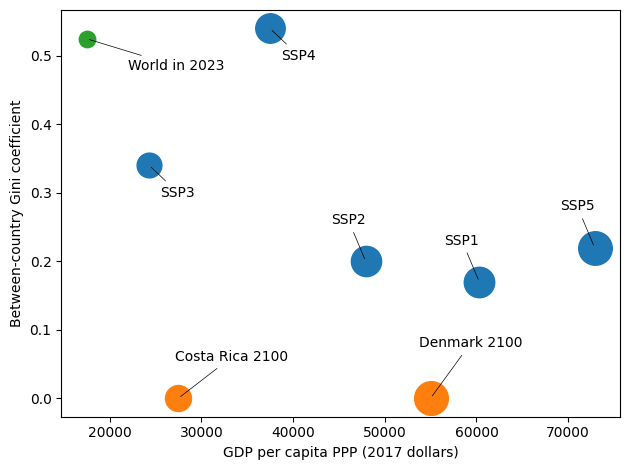

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# Import the data
scenario_classification_inequality = pd.read_csv('./data/scenario_classification_inequality.csv', sep=';')

# Predefined label positions for each scenario
label_positions = {
    'SSP1': (0.05, 0.05),
    'SSP2': (0.05, 0.05),
    'SSP3': (5000, -0.05),
    'SSP4': (5000, -0.05),
    'SSP5': (0.05, 0.05),
    'Denmark 2100': (10000, 0.07),
    'Costa Rica 2100': (12000, 0.05),
    'World in 2023': (15000, -0.05)

}

fig, ax = plt.subplots()
category_color_mapping = {category: color for category, color in zip(scenario_classification_inequality['category'].unique(), cm.tab10.colors)}
categories_appeared = set()

for scenario in scenario_classification_inequality['scenario_name'].unique():
    scenario_data = scenario_classification_inequality[scenario_classification_inequality['scenario_name'] == scenario]
    category = scenario_data['category'].values[0]
    
    if category in categories_appeared:
        label = None
    else:
        label = category
        categories_appeared.add(category)

    size = scenario_data['total_gdp'] / 1e12  # Adjust size for visibility if necessary
    
    # Plot each scenario
    scatter = ax.scatter(scenario_data['GDPpc'], 
                         scenario_data['between_country_gini'],
                         s=size,
                         color=category_color_mapping[category],
                         label=label)
    
    # Manually set the position of the text for each scenario using predefined offsets
    for i, txt in enumerate(scenario_data['scenario_name']):
        offset = label_positions.get(txt)  # Use predefined offset or default
        print(offset)
        x_position = scenario_data['GDPpc'].values[i] + offset[0]
        print(x_position)
        y_position = scenario_data['between_country_gini'].values[i] + offset[1]
        print(y_position)
        
        # Draw line from marker to text
        ax.annotate(txt, 
                    xy=(scenario_data['GDPpc'].values[i], scenario_data['between_country_gini'].values[i]), 
                    xytext=(x_position, y_position),
                    textcoords="data",
                    ha='right', 
                    va='bottom',
                    arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# Label the axes
ax.set_xlabel('GDP per capita PPP (2017 dollars)')
ax.set_ylabel('Between-country Gini coefficient')
plt.tight_layout()
plt.show()

### Check how relationship, scaling law between pba emissions pc and ppp gdp pc changes over time.

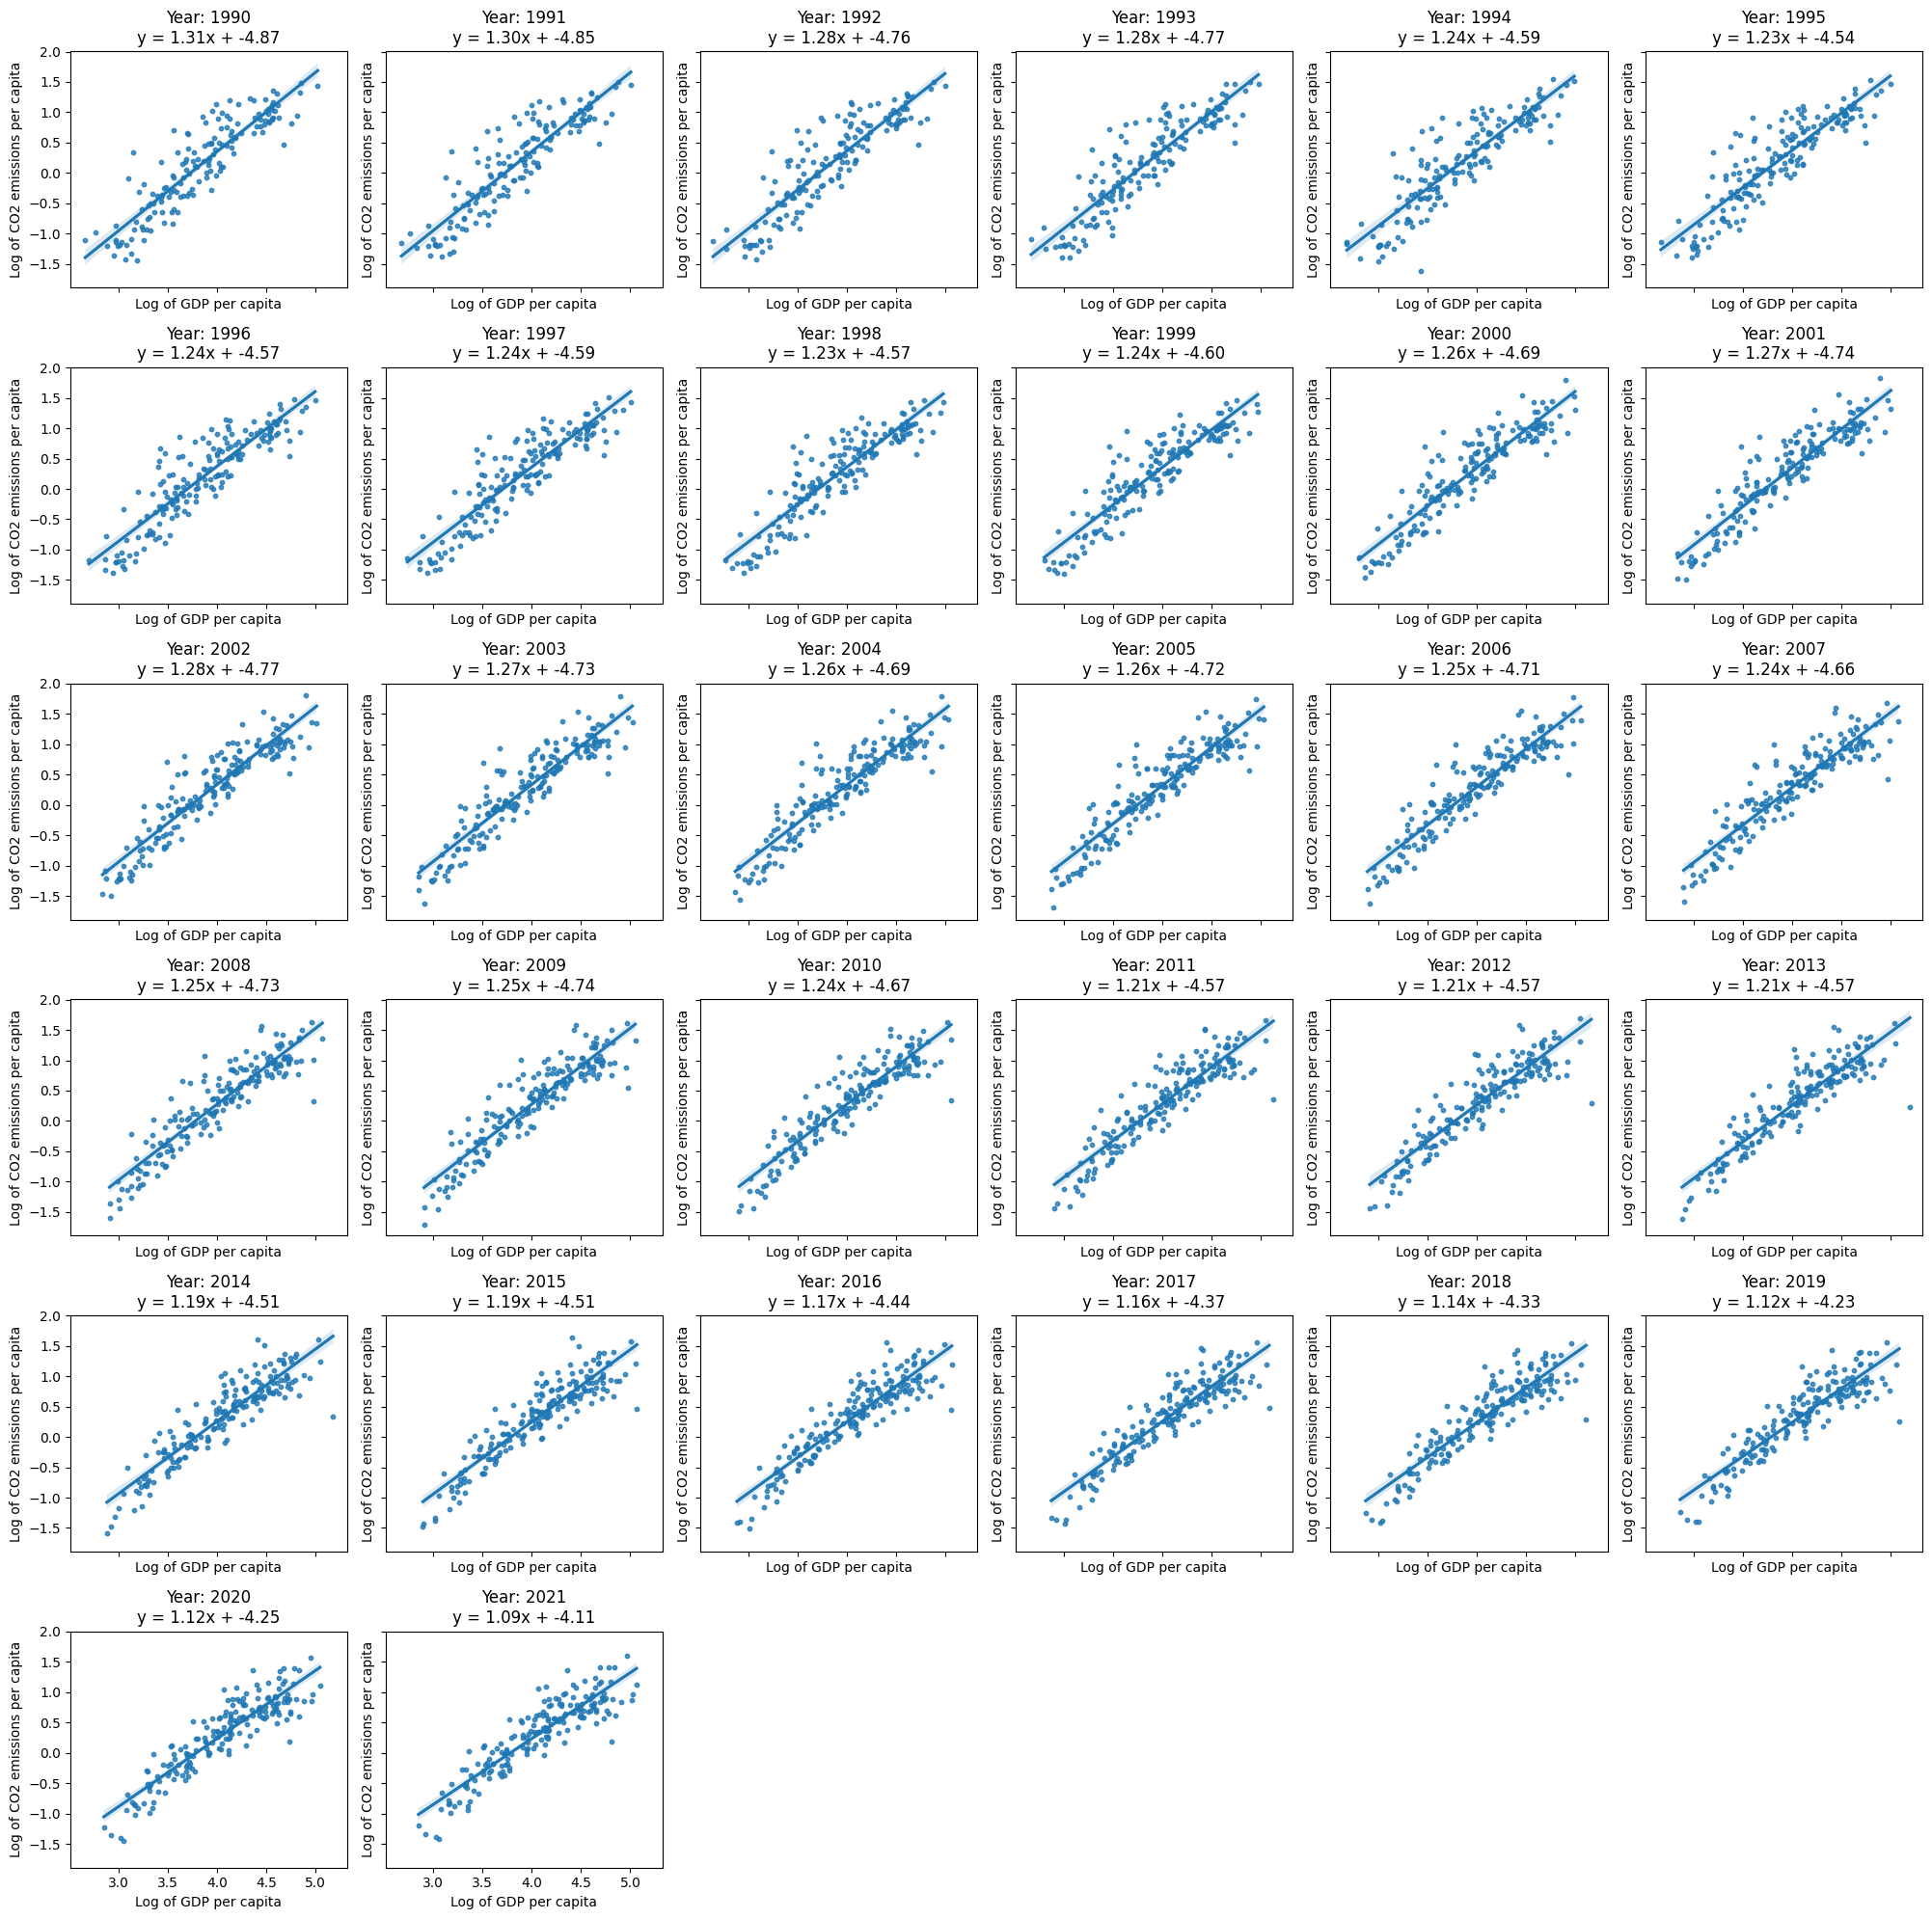

In [15]:
# import csv dataset called co2-emissions-and-gdp-per-capita
co2_emissions_and_gdp_per_capita = pd.read_csv('./data/co2-emissions-and-gdp-per-capita.csv', sep=';')

# find unique years in colum Year of the dataframe co2_emissions_and_gdp_per_capita
years = co2_emissions_and_gdp_per_capita['Year'].unique()

# now loop over all years and plot the co2 emissions per capita against the gdp per capita for each year over all countries
# If a country has no data for a specific year, skip it (it is also just not included in the dataframe) plot all the years in the same plot as different panel so like from 
# the earliest year to the latest possible year in the dataset

# Assuming seaborn is already installed. If not, you should install it using pip or conda.
# Seaborn is used for enhanced data visualization.

# import csv dataset called co2-emissions-and-gdp-per-capita
co2_emissions_and_gdp_per_capita = pd.read_csv('./data/co2-emissions-and-gdp-per-capita.csv', sep=';')

# find unique years in column 'Year' of the dataframe co2_emissions_and_gdp_per_capita
years = co2_emissions_and_gdp_per_capita['Year'].unique()

# set up the matplotlib figure
# Calculate the dimensions of the grid
grid_size = ceil(sqrt(len(years)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20), sharex=True, sharey=True)

# Flatten the array of axes for easy iteration
axes_flat = axes.flatten()

# Initialize lists to store regression coefficients
slopes = []
intercepts = []
plot_years = []


# Now loop over all years and plot the co2 emissions per capita against the gdp per capita for each year over all countries
for index, year in enumerate(sorted(years)):
    ax = axes_flat[index]
    
    # filter the dataframe for the current year
    data_for_year = co2_emissions_and_gdp_per_capita[co2_emissions_and_gdp_per_capita['Year'] == year]
    
    # Apply log transformation to x and y
    data_for_year = data_for_year.assign(
        log_gdp_pc=np.log10(data_for_year['gdp_pc']),
        log_pba_annual_emissions_pc=np.log10(data_for_year['pba_annual_emissions_pc'])
    )
    
    
    # Scatter plot with regression line
    sns.regplot(data=data_for_year, x='log_gdp_pc', y='log_pba_annual_emissions_pc', ax=ax, scatter_kws={'s': 10})
    
    # Calculate the regression line equation
    slope, intercept = np.polyfit(data_for_year['log_gdp_pc'].dropna(), data_for_year['log_pba_annual_emissions_pc'].dropna(), 1)
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    
    # Set the title to the current year and display the regression line equation
    ax.set_title(f'Year: {year}\n{equation}')
    ax.set_xlabel('Log of GDP per capita')
    ax.set_ylabel('Log of CO2 emissions per capita')

    # Save coefficients
    slopes.append(slope)
    intercepts.append(intercept)
    plot_years.append(year)
    

# Adjust the layout so the subplots fit into the figure area
plt.tight_layout()

# Hide the remaining empty subplots if any
for ax in axes_flat[index+1:]:
    ax.set_visible(False)

# Show the plot
plt.show()

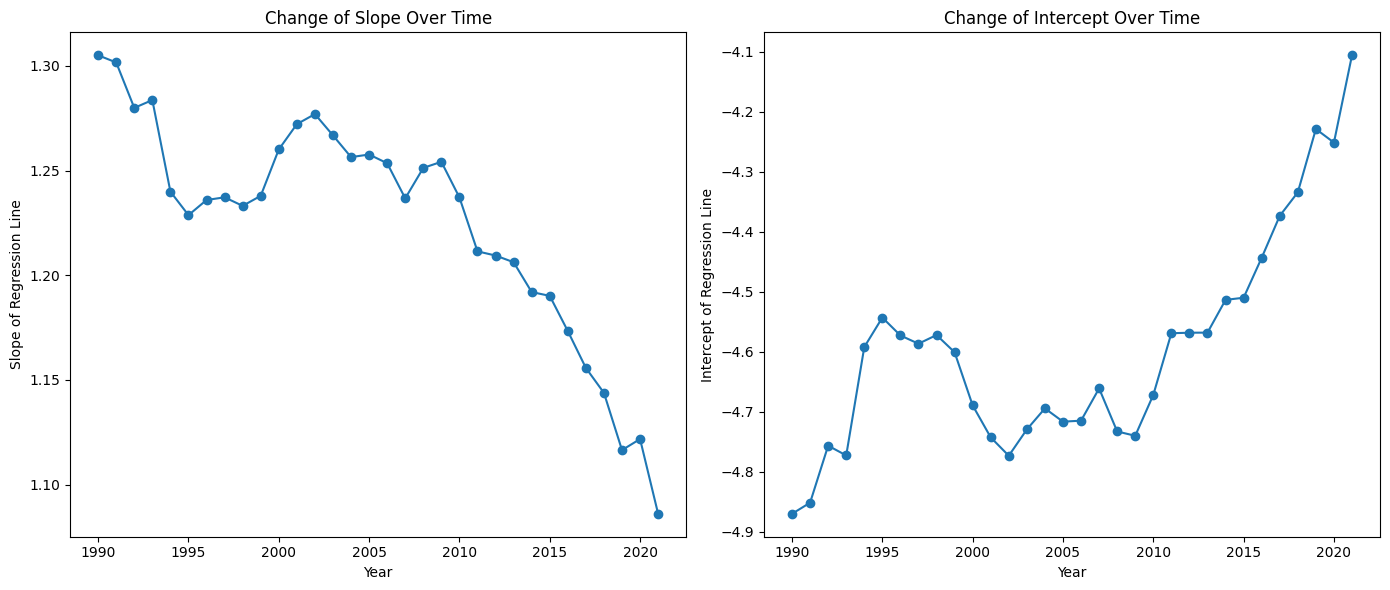

In [16]:
# Now plot the regression coefficients over time
plt.figure(figsize=(14, 6))

# Plot slopes
plt.subplot(1, 2, 1)
plt.plot(plot_years, slopes, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Slope of Regression Line')
plt.title('Change of Slope Over Time')

# Plot intercepts
plt.subplot(1, 2, 2)
plt.plot(plot_years, intercepts, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Intercept of Regression Line')
plt.title('Change of Intercept Over Time')

plt.tight_layout()
plt.show()

## check high income countries and other country groups whether per capita carbon emission declines depend on income group. plot different groups first 

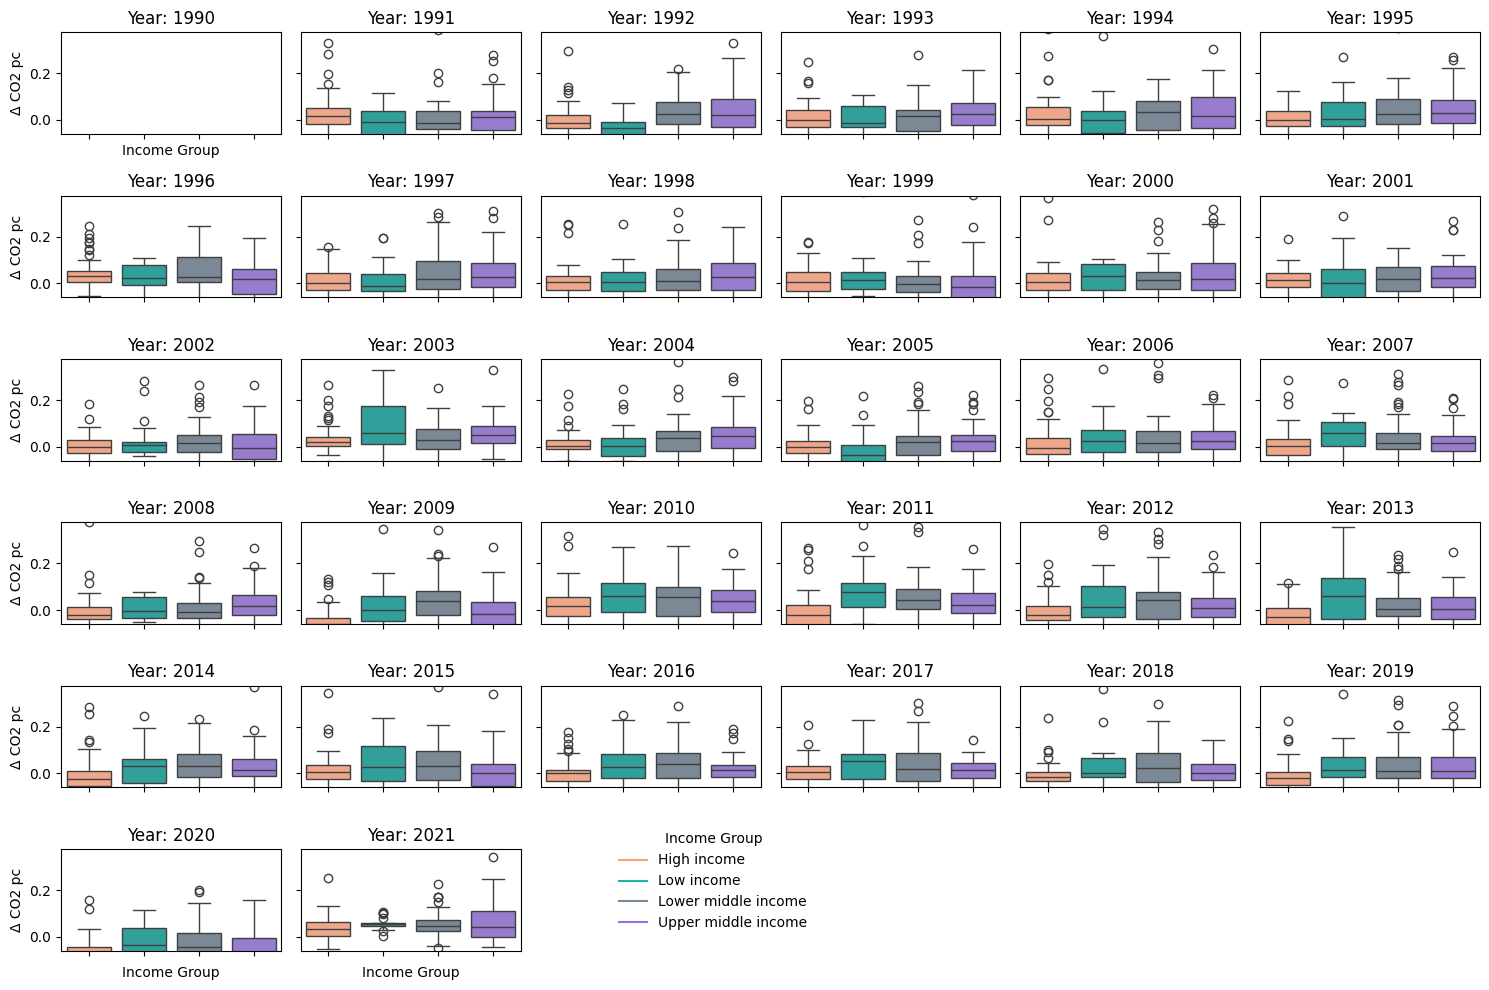

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# Import CSV dataset called co2-emissions-and-gdp-per-capita
co2_emissions_and_gdp_per_capita = pd.read_csv('./data/co2-emissions-and-gdp-per-capita.csv', sep=';')

# Add a column for the annual change rate; initialized with NaN
co2_emissions_and_gdp_per_capita['annual_change_rate'] = float('nan')

# Compute the annual change rate for each country
co2_emissions_and_gdp_per_capita = co2_emissions_and_gdp_per_capita.sort_values(by=['Code', 'Year'])
co2_emissions_and_gdp_per_capita['annual_change_rate'] = co2_emissions_and_gdp_per_capita.groupby('Code')['pba_annual_emissions_pc'].pct_change()

# Get unique years and income groups
years = co2_emissions_and_gdp_per_capita['Year'].unique()
income_groups = co2_emissions_and_gdp_per_capita['income_group'].unique()

# Calculate the dimensions of the grid
grid_rows = ceil(sqrt(len(years)))
grid_cols = ceil(len(years) / grid_rows)

# Define colors for each income group
colors = ["#FFA07A", "#20B2AA", "#778899", "#9370DB"]  # LightSalmon, LightSeaGreen, LightSlateGray, MediumPurple
palette = dict(zip(sorted(income_groups), colors))

# Set up the matplotlib figure
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 10), sharex=True, sharey=True)

# Flatten the array of axes for easy iteration
axes_flat = axes.flatten()

# Loop over all years and plot
for index, year in enumerate(sorted(years)):
    ax = axes_flat[index]
    # Filter the data for the current year and exclude the NaN change rates
    data_for_year = co2_emissions_and_gdp_per_capita[
        (co2_emissions_and_gdp_per_capita['Year'] == year) & 
        ~co2_emissions_and_gdp_per_capita['annual_change_rate'].isna()
    ]
    
    # Create a boxplot for the annual change rate across income groups
    sns.boxplot(
        data=data_for_year, 
        x='income_group', 
        y='annual_change_rate', 
        hue='income_group',
        ax=ax, 
        order=sorted(income_groups),
        palette=palette,
        dodge=False,
        legend=False
    )
    
    ax.set_title(f'Year: {year}')
    ax.set_ylabel('Δ CO2 pc')
    ax.set_xlabel('Income Group')

    # Optional: Calculate the y-limits based on the data
    # Calculate the y-limits based on the data, ensuring there are no NaN or Inf values
    buffer = 0.1  # This is the buffer to add above and below the range of the data
    change_rates = data_for_year['annual_change_rate'].dropna()
    if not change_rates.empty:
        min_val = change_rates.min()
        max_val = change_rates.max()
        lower_limit = min_val - (abs(min_val) * buffer)
        upper_limit = max_val + (abs(max_val) * buffer)
        
        # Set the y-limits for the current ax, ensuring limits are finite
        if np.isfinite(lower_limit) and np.isfinite(upper_limit):
            ax.set_ylim(lower_limit, upper_limit)
        else:
            ax.set_ylim(min_val, max_val)  # Fallback to data range if buffer calculation fails

    # Set x-axis tick labels for the bottom row only
    if index < len(years) - grid_cols:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Income Group')

    # Capture and write out the labels of the income groups with colors etc. to use for the legend
    # If this is the second to last plot in the grid, we will use the next subplot location for the legend
    if index == len(years) - 2:
        # Create an empty boxplot to use its handle for the legend
        for income_group, color in palette.items():
            ax.plot([], [], color=color, label=income_group)
        # Place legend in the next subplot's location
        legend_ax = axes_flat[index + 1]
        handles, labels = ax.get_legend_handles_labels()

# Hide the remaining empty subplots if any
for ax in axes_flat[index+1:]:
    ax.set_visible(False)

# Adjust the layout so the subplots fit into the figure area
plt.tight_layout()

# Create the legend, positioning it outside the entire grid
legend_ax = fig.add_axes([0.5, 0.1, 0.05, 0.075])  # Add an axes for the legend ([left, bottom, width, height])
legend_ax.legend(handles, labels, title='Income Group', frameon=False)
legend_ax.axis('off')  # Hide the axis

# Show the plot
plt.show()


# Check whether differences between high income countries and other groups are statistically significant

In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Assuming the plotting code remains unchanged and goes above this

# Perform one-way ANOVA for each year to check for overall differences among income groups
print("ANOVA and Tukey's HSD Test Results by Year:")
for year in sorted(years):
    data_for_year = co2_emissions_and_gdp_per_capita[
        (co2_emissions_and_gdp_per_capita['Year'] == year) & 
        ~co2_emissions_and_gdp_per_capita['annual_change_rate'].isna()
    ]
    
    if not data_for_year.empty:
        # Perform one-way ANOVA
        model = ols('annual_change_rate ~ income_group', data=data_for_year).fit()
        anova_result = sm.stats.anova_lm(model, typ=2)
        
        print(f"\nYear: {year}")
        print(anova_result)
        
        # If ANOVA shows significant results, proceed with Tukey's HSD
        if anova_result['PR(>F)'].iloc[0] < 0.05:
            print("Significant differences found. Proceeding with Tukey's HSD:")
            tukey = pairwise_tukeyhsd(endog=data_for_year['annual_change_rate'], groups=data_for_year['income_group'], alpha=0.05)
            print(tukey)
        else:
            print("No significant differences found among income groups.")
    else:
        print(f"\nYear: {year} - No data available for analysis.")

ANOVA and Tukey's HSD Test Results by Year:

Year: 1990 - No data available for analysis.

Year: 1991
                sum_sq     df         F    PR(>F)
income_group  0.043026    3.0  1.483737  0.221233
Residual      1.469238  152.0       NaN       NaN
No significant differences found among income groups.

Year: 1992
                sum_sq     df         F    PR(>F)
income_group  0.091474    3.0  2.644877  0.051197
Residual      1.775389  154.0       NaN       NaN
No significant differences found among income groups.

Year: 1993
                sum_sq     df         F    PR(>F)
income_group  0.024389    3.0  0.527777  0.663838
Residual      2.433810  158.0       NaN       NaN
No significant differences found among income groups.

Year: 1994
                  sum_sq     df         F    PR(>F)
income_group    3.164109    3.0  0.740751  0.529239
Residual      226.389012  159.0       NaN       NaN
No significant differences found among income groups.

Year: 1995
                 sum_sq     

### Check country trajectories phase space of carbon emissions and gdp per capita

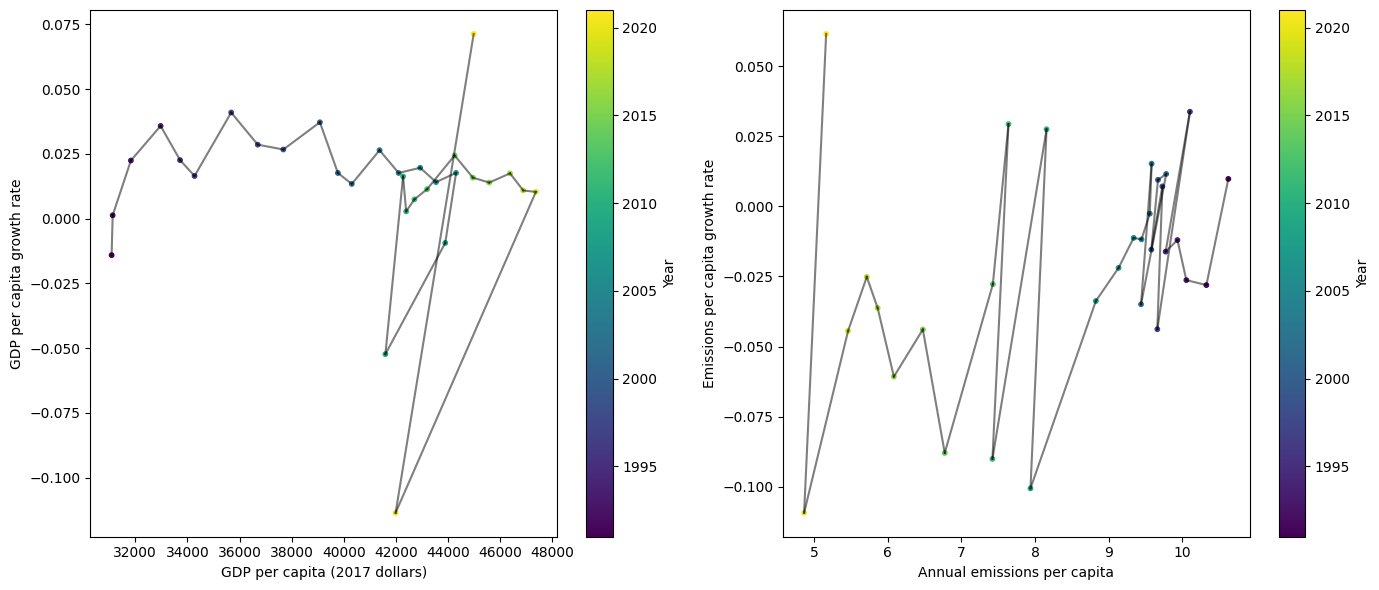

In [19]:
# Import the dataset
co2_emissions_and_gdp_per_capita = pd.read_csv('./data/co2-emissions-and-gdp-per-capita.csv', sep=';')

# Filter data for the specified country and remove rows with missing data
country = 'GBR'
filtered_data = co2_emissions_and_gdp_per_capita[(co2_emissions_and_gdp_per_capita['Code'] == country) & 
                                                 co2_emissions_and_gdp_per_capita['gdp_pc'].notnull() & 
                                                 co2_emissions_and_gdp_per_capita['pba_annual_emissions_pc'].notnull()]

# Calculate growth rates for GDP per capita and annual emissions per capita
growth_data = filtered_data[['Year', 'gdp_pc', 'pba_annual_emissions_pc']].sort_values('Year')
growth_data['gdp_pc_growth'] = growth_data['gdp_pc'].pct_change()
growth_data['emissions_pc_growth'] = growth_data['pba_annual_emissions_pc'].pct_change()

# Remove the first row since growth rates are NaN
growth_data = growth_data.iloc[1:]

# Set up a 1x2 grid plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# First panel: GDP per capita vs. GDP growth rate
sc1 = axs[0].scatter(growth_data['gdp_pc'], growth_data['gdp_pc_growth'], c=growth_data['Year'], cmap='viridis', s=10)
fig.colorbar(sc1, ax=axs[0], label='Year')
for i in range(len(growth_data)-1):
    axs[0].plot(growth_data['gdp_pc'].iloc[i:i+2], growth_data['gdp_pc_growth'].iloc[i:i+2], color = 'black', linestyle='-', alpha=0.5)
axs[0].set_xlabel('GDP per capita (2017 dollars)')
axs[0].set_ylabel('GDP per capita growth rate')

# Second panel: Annual emissions per capita vs. emissions growth rate
sc2 = axs[1].scatter(growth_data['pba_annual_emissions_pc'], growth_data['emissions_pc_growth'], c=growth_data['Year'], cmap='viridis', s=10)
fig.colorbar(sc2, ax=axs[1], label='Year')
for i in range(len(growth_data)-1):
    axs[1].plot(growth_data['pba_annual_emissions_pc'].iloc[i:i+2], growth_data['emissions_pc_growth'].iloc[i:i+2], color = 'black', linestyle='-', alpha=0.5)
axs[1].set_xlabel('Annual emissions per capita')
axs[1].set_ylabel('Emissions per capita growth rate')

plt.tight_layout()
plt.show()

In [20]:
# Assuming df is your DataFrame with columns 'Code', 'Year', 'gdp_pc', 'pba_annual_emissions_pc'
df = co2_emissions_and_gdp_per_capita

# Calculate yearly growth rates for GDP and emissions
df['gdp_pc_growth'] = df.groupby('Code')['gdp_pc'].pct_change()
df['emissions_pc_growth'] = df.groupby('Code')['pba_annual_emissions_pc'].pct_change()

# Drop rows with NaN values in growth rate columns (first year for each country)
df.dropna(subset=['gdp_pc_growth', 'emissions_pc_growth'], inplace=True)

# Initialize a dictionary to store correlation results
correlations = {}

# Loop through each country and calculate the correlation between GDP growth and emissions growth
for country in df['Code'].unique():
    country_data = df[df['Code'] == country]
    correlation = country_data['gdp_pc_growth'].corr(country_data['emissions_pc_growth'])
    correlations[country] = correlation

# Convert the correlations dictionary to a DataFrame for easier analysis
correlations_df = pd.DataFrame(list(correlations.items()), columns=['Country', 'Correlation'])

# Analyze the results
print(correlations_df)

    Country  Correlation
0       AFG     0.403380
1       ALB     0.517221
2       DZA     0.307159
3       AGO     0.015990
4       ATG     0.500282
..      ...          ...
185     UZB    -0.138095
186     VUT    -0.061804
187     VNM     0.477209
188     ZMB     0.157143
189     ZWE     0.566567

[190 rows x 2 columns]


C:\Users\yoswald\AppData\Local\Temp\ipykernel_22624\3070503196.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_data = df.groupby('Code').apply(lambda x: x['gdp_pc_growth'].corr(x['emissions_pc_growth']))


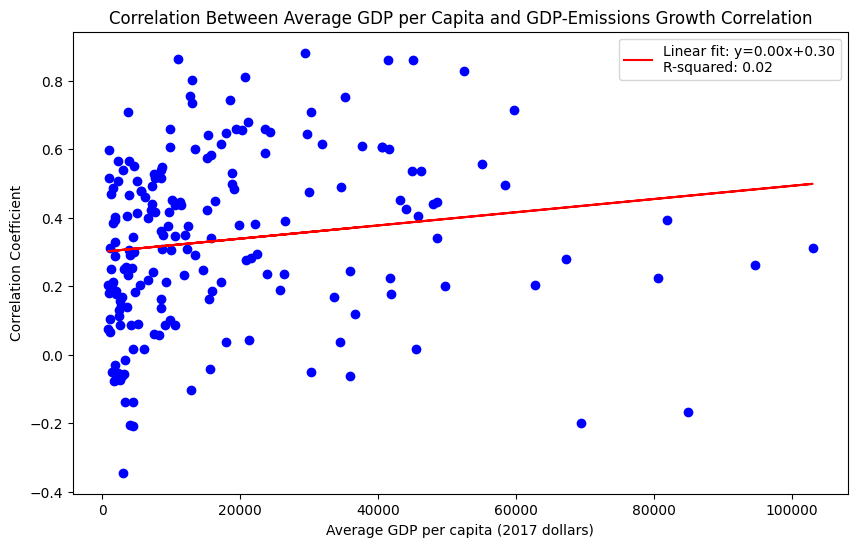

Correlation between the country's average GDP per capita and the correlation coefficient between GDP growth and emissions growth: 0.151


In [21]:

# Assuming df is the DataFrame with your dataset
df = pd.read_csv('./data/co2-emissions-and-gdp-per-capita.csv', sep=';')

# Calculate yearly growth rates for GDP and emissions
df['gdp_pc_growth'] = df.groupby('Code')['gdp_pc'].pct_change()
df['emissions_pc_growth'] = df.groupby('Code')['pba_annual_emissions_pc'].pct_change()

# Remove the first row for each country since growth rates will be NaN
df = df.dropna(subset=['gdp_pc_growth', 'emissions_pc_growth'])

# Calculate the average GDP per capita for each country
avg_gdp_per_country = df.groupby('Code')['gdp_pc'].mean()

# Calculate correlation between GDP growth and emissions growth for each country
correlation_data = df.groupby('Code').apply(lambda x: x['gdp_pc_growth'].corr(x['emissions_pc_growth']))

# Combine average GDP per capita and correlation data into a single DataFrame
combined_data = pd.DataFrame({'Average_GDP_pc': avg_gdp_per_country, 'Correlation': correlation_data}).dropna()


# Scatter plot of average GDP per capita vs. correlation coefficient
plt.figure(figsize=(10, 6))
plt.scatter(combined_data['Average_GDP_pc'], combined_data['Correlation'], color='blue')

# Apply a linear fit
slope, intercept, r_value, p_value, std_err = linregress(combined_data['Average_GDP_pc'], combined_data['Correlation'])
line = slope * combined_data['Average_GDP_pc'] + intercept
plt.plot(combined_data['Average_GDP_pc'], line, 'r', label=f'Linear fit: y={slope:.2f}x+{intercept:.2f}\nR-squared: {r_value**2:.2f}')

plt.xlabel('Average GDP per capita (2017 dollars)')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Between Average GDP per Capita and GDP-Emissions Growth Correlation')
plt.legend()
plt.show()

# Now, check if the correlation coefficient depends on the average GDP level of the country
correlation_between_gdp_and_correlation = combined_data['Average_GDP_pc'].corr(combined_data['Correlation'])

print(f"Correlation between the country's average GDP per capita and the correlation coefficient between GDP growth and emissions growth: {correlation_between_gdp_and_correlation:.3f}")